# CS 598 Deep Learning for Healthcare : Multi-Label Chest X-Ray Classification
### Authors : Aravind Pillai

# Imports

In [1]:
### Imports
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
import gc
import warnings
warnings.filterwarnings("ignore")
import sys
import time
####
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
####
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim
import torchvision.transforms as transforms
import torchvision
##
from fastprogress import master_bar, progress_bar
from PIL import Image
gc.collect()

0

In [2]:
print(time.strftime("%H:%M:%S",time.localtime()))

22:15:11


## Load the Data and Paths

In [3]:
path='/home/ubuntu/input/'
out='/home/ubuntu/models/'

In [4]:
chestxrays_root = Path(path)
data_path = chestxrays_root
####

full_train_df = pd.read_csv(path+'CheXpert-v1.0-small/train.csv')
full_valid_df = pd.read_csv(path+'CheXpert-v1.0-small/valid.csv')

full_train_df['patient'] = full_train_df.Path.str.split('/',3,True)[2]
full_train_df  ['study'] = full_train_df.Path.str.split('/',4,True)[3]

full_valid_df['patient'] = full_valid_df.Path.str.split('/',3,True)[2]
full_valid_df  ['study'] = full_valid_df.Path.str.split('/',4,True)[3]

print("Train Data : ",len(full_train_df))

full_train_df.head()

Train Data :  223414


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,patient00002,study2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002,study1
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002,study1
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,patient00003,study1


## Input Data Plots
### Analyze Input Data

In [5]:
cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices']

data_df = []

for i in cols:
    minusOneVal = sum(np.where(full_train_df[i] == -1,1,0))
    oneVal = sum(np.where(full_train_df[i] == 1,1,0))
    zeroVal = sum(np.where(full_train_df[i] == 0,1,0))
    #nanVal = sum(np.where(full_train_df[i] == np.NaN ,1,0))
    nanVal = full_train_df[i].isnull().sum()
    data_df.append([i,minusOneVal,oneVal,zeroVal,nanVal])
    
data_df = pd.DataFrame(data_df)
data_df.columns = ['Label','minusOneVal','oneVal','zeroVal','nanVal']
data_df

,Label,minusOneVal,oneVal,zeroVal,nanVal
0,No Finding,0,22381,0,201033
1,Enlarged Cardiomediastinum,12403,10798,21638,178575
2,Cardiomegaly,8087,27000,11116,177211
3,Lung Opacity,5598,105581,6599,105636
4,Lung Lesion,1488,9186,1270,211470
5,Edema,12984,52246,20726,137458
6,Consolidation,27742,14783,28097,152792
7,Pneumonia,18770,6039,2799,195806
8,Atelectasis,33739,33376,1328,154971
9,Pneumothorax,3145,19448,56341,144480


### Plot input Data

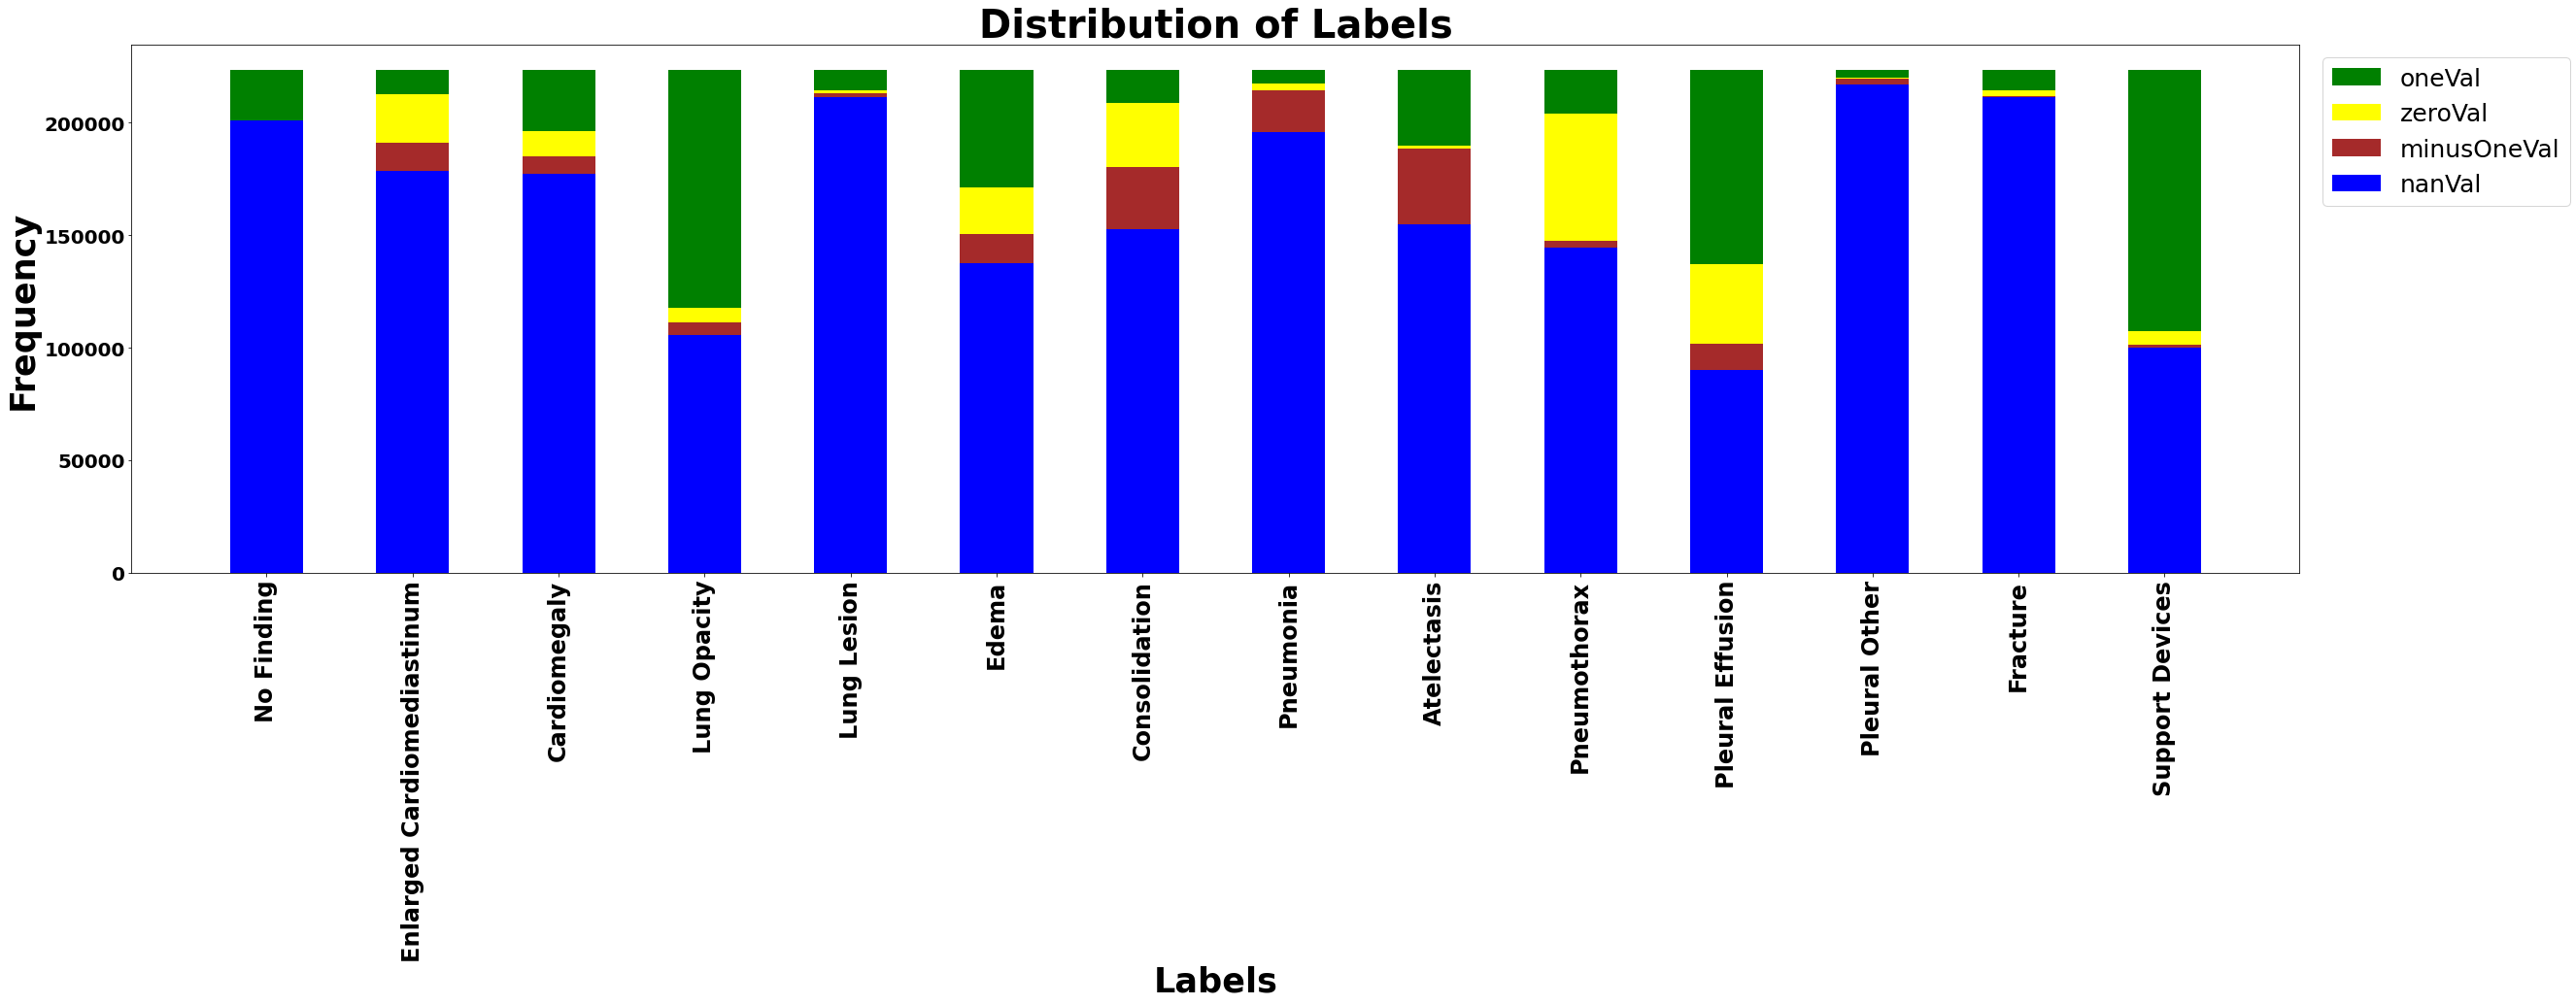

In [6]:
plt.figure(figsize=(40,10))
Label = data_df['Label']
nanVal = data_df['nanVal']
minusOneVal = data_df['minusOneVal']
zeroVal = data_df['zeroVal']
oneVal = data_df['oneVal']

ind = [x for x, _ in enumerate(Label)]

plt.bar(Label, oneVal, width=0.5, label='oneVal', color='green', bottom=zeroVal+minusOneVal+nanVal)
plt.bar(Label, zeroVal, width=0.5, label='zeroVal', color='yellow', bottom=minusOneVal+nanVal)
plt.bar(Label, minusOneVal, width=0.5, label='minusOneVal', color='brown',bottom=nanVal)
plt.bar(Label, nanVal, width=0.5, label='nanVal', color='blue')

plt.yticks(fontsize=20,fontweight='bold')

plt.xticks(ind, Label,fontsize=24,fontweight='bold',rotation=90)
plt.ylabel("Frequency",fontsize=35,fontweight='bold')
plt.xlabel("Labels",fontsize=35,fontweight='bold')
plt.legend(bbox_to_anchor=(1.005, 1),fontsize=25)
#plt.legend(bbox_to_anchor=(1.005, 1))
plt.title("Distribution of Labels",fontsize=40, fontweight='bold')

plt.show()

## Handling Uncertainities - U_one and U_zero

Since this model is used as a first pass for chest x-ray diagnosis, false negative has higher cost and all uncertainties were 
consdiered as positive (replaced -1 by 1)

In [7]:
u_one_features = ['Atelectasis', 'Edema']
u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']

full_train_df['Cardiomegaly'] = full_train_df['Cardiomegaly'].replace(-1,0)
full_train_df['Consolidation'] = full_train_df['Consolidation'].replace(-1,0)
full_train_df['Pleural Effusion'] = full_train_df['Pleural Effusion'].replace(-1,0)

full_train_df['Atelectasis'] = full_train_df['Atelectasis'].replace(-1,1)
full_train_df['Edema'] = full_train_df['Edema'].replace(-1,1)
full_train_df = full_train_df.replace(-1,np.nan)
full_train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,0.0,1.0,NaN,...,0.0,NaN,1.0,NaN,0.0,NaN,1.0,NaN,patient00002,study2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002,study1
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002,study1
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,patient00003,study1


## Get Sample Data - Only to Run Test

In [8]:
TEST_FLAG = 'N'
if TEST_FLAG == 'Y':
    sample_perc = 0.01
    unique_patients = full_train_df.patient.unique()
    mask = np.random.rand(len(unique_patients)) <= sample_perc
    sample_patients = unique_patients[mask]
    full_train_df = full_train_df[full_train_df.patient.isin(sample_patients)]
    
full_train_df = full_train_df.drop(['patient', 'study'],axis=1)
print(full_train_df.Path.size)

223414


## Get Labels

In [9]:
LABELS = full_train_df.columns[5:]
LABELS

Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices'],
      dtype='object')

# Split Test & Train

In [10]:
train_data, val_data = train_test_split(full_train_df, test_size=0.20, random_state=2021)
del full_train_df
del full_valid_df
gc.collect()
print(train_data.Path.size)
print(val_data.Path.size)

178731
44683


# Define Models

<ol>
<li> Custom Net 
<li> Densenet121 
<li> Resnet50 - Freeze first 6 layers
<li> Inception_V3 - Freeze first 8 layers 
<li>  Vgg16 - Freeze first 6 layers
<ol>
    

### Custom Model CNN

In [11]:
class CustomNet(nn.Module):
    def __init__(self, num_classes=14, is_trained=False):
        super().__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(3, 8, 3), # inp (3, 512, 512)
            nn.Conv2d(8, 16, 3),
            nn.MaxPool2d(2),
            nn.ReLU() # op (16, 256, 256)
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(16, 32, 5), # inp (16, 256, 256)
            nn.Conv2d(32, 32, 3),
            nn.MaxPool2d(4),
            nn.ReLU() # op (32, 64, 64)
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3), # inp (32, 64, 64)
            nn.Conv2d(64, 64, 5),
            nn.MaxPool2d(2),
            nn.ReLU() # op (64, 32, 32)
        )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(64, 128, 5), # inp (64, 32, 32)
            nn.Conv2d(128, 128, 3),
            nn.MaxPool2d(2),
            nn.ReLU() # op (128, 16, 16)
        )
        #self.Lin1 = nn.Linear(15488, 15)
        self.Lin1 = nn.Sequential(nn.Linear(512, 14), nn.Sigmoid())        
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = x.view(x.size(0), -1)
        #print(x.size())
        x = self.Lin1(x)
       
        
        return x

### Pre Trained Models

In [12]:
"""
        Init model architecture
        
        Parameters
        ----------
        num_classes: int
            number of classes
        is_trained: bool
            whether using pretrained model from ImageNet or not
"""
####################################################################################
###   DenseNet121
####################################################################################
#
class DenseNet121(nn.Module):
    def __init__(self, num_classes=14, is_trained=False):

        super().__init__()
        self.net = torchvision.models.densenet121(pretrained=is_trained)
        # Get the input dimension of last layer
        kernel_count = self.net.classifier.in_features            
        self.net.classifier = nn.Sequential(nn.Linear(kernel_count, num_classes), nn.Sigmoid())
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)
    
####################################################################################
###   ResNet50
####################################################################################
#
class ResNet50(nn.Module):
    def __init__(self, num_classes=14, is_trained=False):

        super().__init__()
        self.net = torchvision.models.resnet50(pretrained=is_trained)
        # Get the input dimension of last layer
        #kernel_count = self.net.classifier.in_features

        ## Freeze first 8 layers
        ct = 0
        for child in self.net.children():
            ct += 1
            if ct < 9:
                for param in child.parameters():
                    param.requires_grad = False
                
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.net.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 14),nn.Sigmoid())
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)
    
####################################################################################
###   INCEPTION
####################################################################################
#
class Inception(nn.Module):
    def __init__(self, num_classes=14, is_trained=False):

        super().__init__()
        self.net = torchvision.models.inception_v3(pretrained=is_trained,aux_logits = False)
        # Get the input dimension of last layer
        #kernel_count = self.net.classifier.in_features
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        #self.net.classifier = nn.Sequential(nn.Linear(kernel_count, num_classes), nn.Sigmoid())
        
        ## Freeze first 20 layers
        ct = 0
        for child in self.net.children():
            ct += 1
            if ct < 21:
                for param in child.parameters():
                    param.requires_grad = False
                    
        self.net.fc = nn.Sequential(nn.Linear(self.net.fc.in_features, num_classes), nn.Sigmoid())
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)
    
####################################################################################
###   VGG16
####################################################################################
#
class Vgg16(nn.Module):
    def __init__(self, num_classes=14, is_trained=False):

        super().__init__()
        self.net = torchvision.models.vgg16(pretrained=is_trained)
        
        #for param in self.net.features.parameters():
           # param.require_grad = False
            
        ## Freeze first 6 layers
        ct = 0
        for child in self.net.children():
            ct += 1
            if ct < 7:
                for param in child.parameters():
                    param.requires_grad = False

        # Newly created modules have require_grad=True by default
        num_features = self.net.classifier[6].in_features
        features = list(self.net.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, num_classes)]) # Add our layer with 4 outputs
        self.net.classifier = nn.Sequential(*features, nn.Sigmoid()) # Replace the model classifier
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)


## Create Dataset

In [13]:
class ChestXrayDataset(Dataset):
    
    def __init__(self, folder_dir, dataframe, image_size, normalization):
        """
        Init Dataset
        
        Parameters
        ----------
        folder_dir: str
            folder contains all images
        dataframe: pandas.DataFrame
            dataframe contains all information of images
        image_size: int
            image size to rescale
        normalization: bool
            whether applying normalization with mean and std from ImageNet or not
        """
        self.image_paths = [] # List of image paths
        self.image_labels = [] # List of image labels
        
        # Define list of image transformations
        image_transformation = [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ]
        
        self.image_transformation = transforms.Compose(image_transformation)
        
        # Get all image paths and image labels from dataframe
        for index, row in dataframe.iterrows():
            image_path = os.path.join(folder_dir, row.Path)
            self.image_paths.append(image_path)
            if len(row) < 14:
                labels = [0] * 14
            else:
                labels = []
                for col in row[5:]:
                    if col == 1:
                        labels.append(1)
                    else:
                        labels.append(0)
            self.image_labels.append(labels)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        """
        Read image at index and convert to torch Tensor
        """
        
        # Read image
        image_path = self.image_paths[index]
        image_data = Image.open(image_path).convert("RGB") # Convert image to RGB channels
        
        # TODO: Image augmentation code would be placed here
        
        # Resize and convert image to torch tensor 
        image_data = self.image_transformation(image_data)
        
        return image_data, torch.FloatTensor(self.image_labels[index])

## Training Parameters

In [14]:
IMAGE_SIZE = 224                              # Image size (224x224)
BATCH_SIZE = 96                              
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 30 ##100                              # Maximum number of training epochs

## Training Data

### Train Loader

In [15]:
my_data_path = path
train_dataset = ChestXrayDataset(my_data_path, train_data, IMAGE_SIZE, True)
#train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
for data, label in train_dataloader:
    print(data.size())
    print(label.size())
    break

torch.Size([96, 3, 224, 224])
torch.Size([96, 14])


### Validation Loader

In [16]:
val_dataset = ChestXrayDataset(my_data_path, val_data, IMAGE_SIZE, True)
#val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [17]:
del train_data
del val_data
del train_dataset
del val_dataset
gc.collect()

20

## Set Device

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.cuda.empty_cache()
device

'cuda'

## Evaluation Metrics

### AUROC
### Accuracy
### f1 score
### Precision and Recall

In [19]:
def multi_label_auroc(y_gt, y_pred):
    """ Calculate AUROC for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    auroc = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        try:
            auroc.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
        except ValueError:
            pass
    return auroc

def multi_label_accuracy(y_gt, y_pred):
    """ Calculate AUROC for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    acc = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        acc.append(accuracy_score(gt_np[:, i], np.where(pred_np[:, i]>=0.5,1,0)))
    return acc

def multi_label_f1(y_gt, y_pred):
    """ Calculate f1 for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    f1_out = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        f1_out.append(f1_score(gt_np[:, i], np.where(pred_np[:, i]>=0.5,1,0)))
    return f1_out


def multi_label_precision_recall(y_gt, y_pred):
    """ Calculate precision for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        precision of each class
    """
    precision_out = []
    recall_out = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        p = precision_recall_fscore_support(gt_np[:, i], np.where(pred_np[:, i]>=0.5,1,0),average='binary')
        precision_out.append(p[0])
        recall_out.append(p[1])
    return precision_out,recall_out

**Training Function**

In [20]:
def epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb):
    """
    Epoch training

    Paramteters
    -----------
    epoch: int
      epoch number
    model: torch Module
      model to train
    train_dataloader: Dataset
      data loader for training
    device: str
      "cpu" or "cuda"
    loss_criteria: loss function
      loss function used for training
    optimizer: torch optimizer
      optimizer used for training
    mb: master bar of fastprogress
      progress to log

    Returns
    -------
    float
      training loss
    """
    # Switch model to training mode
    model.train()
    training_loss = 0 # Storing sum of training losses
   
    # For each batch
    for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):
        
        # Move X, Y  to device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear previous gradient
        optimizer.zero_grad()

        # Feed forward the model
        pred = model(images)
        #pred = torch.LongTensor(pred)
        loss = loss_criteria(pred, labels)
        #print("loss is ",loss)

        # Back propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update training loss after each batch
        training_loss += loss.item()

        #mb.child.comment = f'Training loss {training_loss/(batch+1)}'

    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # return training loss
    return training_loss/len(train_dataloader)

**Evaluating Function**

In [21]:
def evaluating(epoch, model, val_loader, device, loss_criteria, mb):
    """
    Validate model on validation dataset
    
    Parameters
    ----------
    epoch: int
        epoch number
    model: torch Module
        model used for validation
    val_loader: Dataset
        data loader of validation set
    device: str
        "cuda" or "cpu"
    loss_criteria: loss function
      loss function used for training
    mb: master bar of fastprogress
      progress to log
  
    Returns
    -------
    float
        loss on validation set
    float
        metric score on validation set
    """

    # Switch model to evaluation mode
    model.eval()

    val_loss = 0                                   # Total loss of model on validation set
    out_pred = torch.FloatTensor().to(device)      # Tensor stores prediction values
    out_gt = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    with torch.no_grad(): # Turn off gradient
        # For each batch
        for step, (images, labels) in enumerate(progress_bar(val_loader, parent=mb)):
            # Move images, labels to device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Update groundtruth values
            out_gt = torch.cat((out_gt,  labels), 0)

            # Feed forward the model
            ps = model(images)
            loss = loss_criteria(ps, labels)

            # Update prediction values
            out_pred = torch.cat((out_pred, ps), 0)

            # Update validation loss after each batch
            val_loss += loss
            #mb.child.comment = f'Validation loss {val_loss/(step+1)}'

    # Clear memory
    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    # return validation loss, and metric score
    val_loss_mean = val_loss/len(val_loader)
    auroc_mean = np.nanmean(np.array(multi_label_auroc(out_gt, out_pred)))
    acc_mean = np.nanmean(np.array(multi_label_accuracy(out_gt, out_pred)))
    f1_mean = np.nanmean(np.array(multi_label_f1(out_gt, out_pred)))
    
    return val_loss_mean,auroc_mean,acc_mean,f1_mean

**Define Optimizer**

In [22]:
def get_opt(modeltxt,model):
    
    if modeltxt == "DenseNet121":
        return optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)
    
    if modeltxt == "ResNet50":
        return optim.Adam(model.parameters())
    
    if modeltxt == "Vgg16":
        return optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    if modeltxt == "CustomNet":
        return optim.Adam(model.parameters())
    
    if modeltxt == "Inception":
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
        
        return optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Train Model

In [23]:
def trainModel(modelname,loss_criteria,modeltxt):
    model = modelname(num_classes=len(LABELS),is_trained=True).to(device)

    optimizer = get_opt(modeltxt,model)
    # Learning rate will be reduced automatically during training
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR,
                                                        patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max', verbose=True)
    best_score = 0
    best_score_acc = 0
    best_score_f1 = 0
    
    model_path = out+modeltxt+".pth"
    out_path = out+modeltxt+"_running.csv"
    training_losses = []
    validation_losses = []
    validation_score = []
    validation_acc = []
    validation_f1 = []


    # Config progress bar
    mb = master_bar(range(MAX_EPOCHS))
    mb.names = ['Train loss', 'Val loss', 'AUROC', 'Accuracy', 'f1 score']
    x = []

    nonimproved_epoch = 0
    start_time = time.time()
    cnt = 1

    # Training each epoch
    for epoch in mb:
        #break
        mb.main_bar.comment = f'Best AUROC score: {best_score}'
        x.append(epoch)

        # Training
        train_loss = epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
        mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
        training_losses.append(train_loss)

        # Evaluating
        val_loss, new_score, new_score_acc, new_score_f1 = evaluating(epoch, model, val_dataloader, device, loss_criteria, mb)

        validation_losses.append(val_loss)
        validation_score.append(new_score)
        validation_acc.append(new_score_acc)
        validation_f1.append(new_score_f1)

        gc.collect()
        # Update learning rate
        lr_scheduler.step(new_score)

        # Update training chart
        mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score] , [x, validation_acc] ,
                         [x, validation_f1]],
                        [0,epoch+1+round(epoch*0.3)], [0,1])

        diff = np.round(time.time() - start_time)
        pd.DataFrame([[epoch,modeltxt,best_score,new_score,diff]]).to_csv(out_path,index=False,mode='a',header=False)
        # Save model
        t2 = 4
        if modeltxt == 'DenseNet121':
            t2 = 6
        if best_score < new_score:
            #mb.write(f"Improve AUROC from {best_score} to {new_score}")    
            best_score = new_score
            best_score_acc = new_score_acc
            best_score_f1 = new_score_f1
            nonimproved_epoch = 0
            best_model = model
            torch.save({"model": model.state_dict(), 
                        "optimizer": optimizer.state_dict(), 
                        "best_score": best_score, 
                        "epoch": epoch, 
                        "lr_scheduler": lr_scheduler.state_dict()}, model_path)
        else: 
            nonimproved_epoch += 1
        if nonimproved_epoch > 5:
            break
            print("Early stopping")
        if time.time() - start_time > 3600*t2:
            break
            print("Out of time")

    
    return best_score,best_score_acc,best_score_f1,best_model
       

## Set Models to Train

In [24]:
model_list = [CustomNet,DenseNet121,ResNet50,Inception,Vgg16]
mName_list = ['CustomNet','DenseNet121','ResNet50','Inception','Vgg16']

In [25]:
#model_list = [DenseNet121]
#mName_list = ['DenseNet121']

## Train Models in a Loop

Processing Model  CustomNet


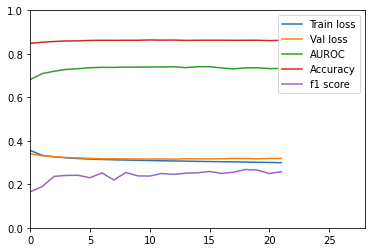

Epoch    22: reducing learning rate of group 0 to 1.0000e-04.
Processing Model  DenseNet121


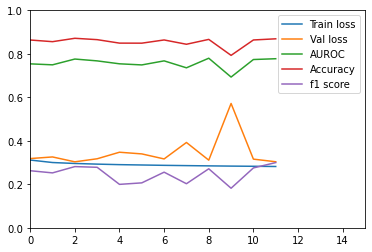

Processing Model  ResNet50


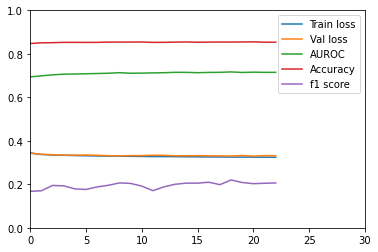

Processing Model  Inception


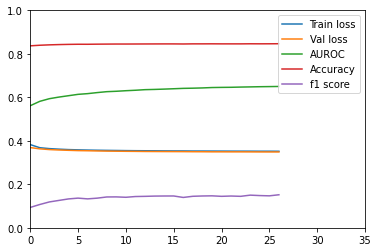

Processing Model  Vgg16


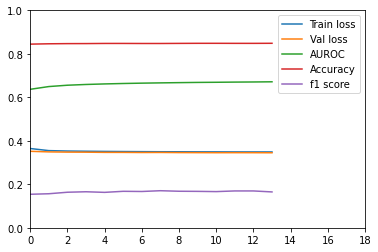

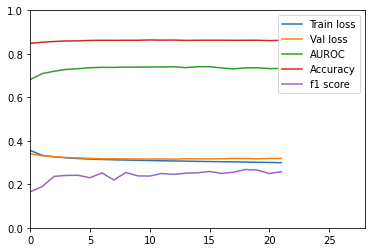

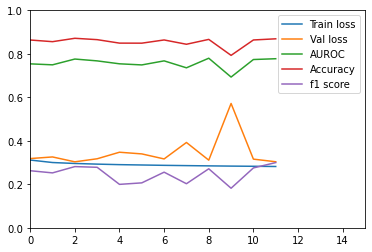

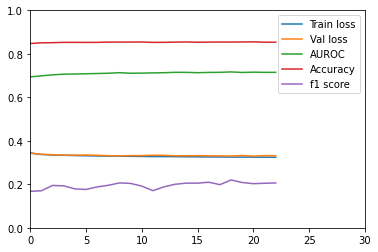

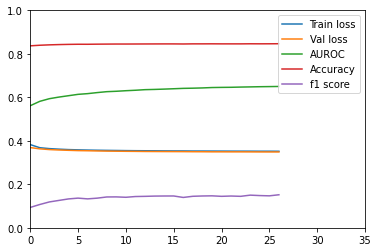

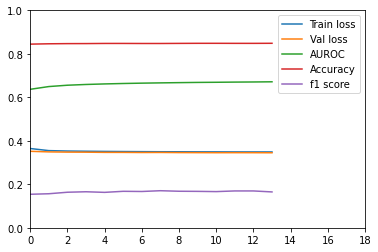

In [26]:
eval_df_train = []
for m in model_list:
    mName = m().__class__.__name__
    print("Processing Model ",mName)
    globals()[f"best_score_{mName}"],globals()[f"best_score_acc_{mName}"],globals()[f"best_score_f1_{mName}"],globals()[f"best_model_{mName}"] = trainModel(modelname=m,loss_criteria=nn.BCELoss(),modeltxt=mName)
    #
    eval_df_train.append([mName,globals()[f"best_score_{mName}"],globals()[f"best_score_acc_{mName}"],globals()[f"best_score_f1_{mName}"]])

## Evaluation Results

In [27]:
eval_df_train=pd.DataFrame(eval_df_train)
eval_df_train.columns = ['Model Name','AUROC', 'Accuracy', 'f1 Score']
eval_df_train.to_csv(out+"eval_df_train.csv",index=False)
eval_df_train

,Model Name,AUROC,Accuracy,f1 Score
0,CustomNet,0.740989,0.862637,0.259044
1,DenseNet121,0.779881,0.866486,0.271429
2,ResNet50,0.716902,0.854088,0.219912
3,Inception,0.650021,0.846562,0.151924
4,Vgg16,0.671470,0.848543,0.164998


## Best model Parameters

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_parameters_all(model):
    return sum(p.numel() for p in model.parameters())

param_list = []
i = 0
for model in model_list:
    modelName = model().__class__.__name__
    num_params_all = count_parameters_all(model())
    num_params = count_parameters(model())
    param_list.append([modelName,num_params_all,num_params])

param_list=pd.DataFrame(param_list)
param_list.columns = ['Model Name','Total Parameters','Trainable Parameters']
param_list

,Model Name,Total Parameters,Trainable Parameters
0,CustomNet,504126,504126
1,DenseNet121,6968206,6968206
2,ResNet50,23772110,264078
3,Inception,21814254,28686
4,Vgg16,134317902,57358


In [29]:
from prettytable import PrettyTable

def count_parameters_pretty(model):
    print(model.__class__.__name__)
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    k = f"Total Trainable Params: {total_params}"
    return k

out1=count_parameters_pretty(best_model_CustomNet)

CustomNet
+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| ConvLayer1.0.weight |    216     |
|  ConvLayer1.0.bias  |     8      |
| ConvLayer1.1.weight |    1152    |
|  ConvLayer1.1.bias  |     16     |
| ConvLayer2.0.weight |   12800    |
|  ConvLayer2.0.bias  |     32     |
| ConvLayer2.1.weight |    9216    |
|  ConvLayer2.1.bias  |     32     |
| ConvLayer3.0.weight |   18432    |
|  ConvLayer3.0.bias  |     64     |
| ConvLayer3.1.weight |   102400   |
|  ConvLayer3.1.bias  |     64     |
| ConvLayer4.0.weight |   204800   |
|  ConvLayer4.0.bias  |    128     |
| ConvLayer4.1.weight |   147456   |
|  ConvLayer4.1.bias  |    128     |
|    Lin1.0.weight    |    7168    |
|     Lin1.0.bias     |     14     |
+---------------------+------------+
Total Trainable Params: 504126


In [30]:
del train_dataloader
del val_dataloader
gc.collect()

63982

# TESTING AND PREDICTION - Based on Unseen Test Data

In [31]:
full_test_df = pd.read_csv(path+'CheXpert-v1.0-small/valid.csv')

## Test Data Distribution

In [32]:
cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices']

data_df = []

for i in cols:
    minusOneVal = sum(np.where(full_test_df[i] == -1,1,0))
    oneVal = sum(np.where(full_test_df[i] == 1,1,0))
    zeroVal = sum(np.where(full_test_df[i] == 0,1,0))
    nanVal = full_test_df[i].isnull().sum()
    data_df.append([i,minusOneVal,oneVal,zeroVal,nanVal])
    
data_df = pd.DataFrame(data_df)

data_df.columns = ['Label','minusOneVal','oneVal','zeroVal','nanVal']
data_df

,Label,minusOneVal,oneVal,zeroVal,nanVal
0,No Finding,0,38,196,0
1,Enlarged Cardiomediastinum,0,109,125,0
2,Cardiomegaly,0,68,166,0
3,Lung Opacity,0,126,108,0
4,Lung Lesion,0,1,233,0
5,Edema,0,45,189,0
6,Consolidation,0,33,201,0
7,Pneumonia,0,8,226,0
8,Atelectasis,0,80,154,0
9,Pneumothorax,0,8,226,0


## Test Data Plot

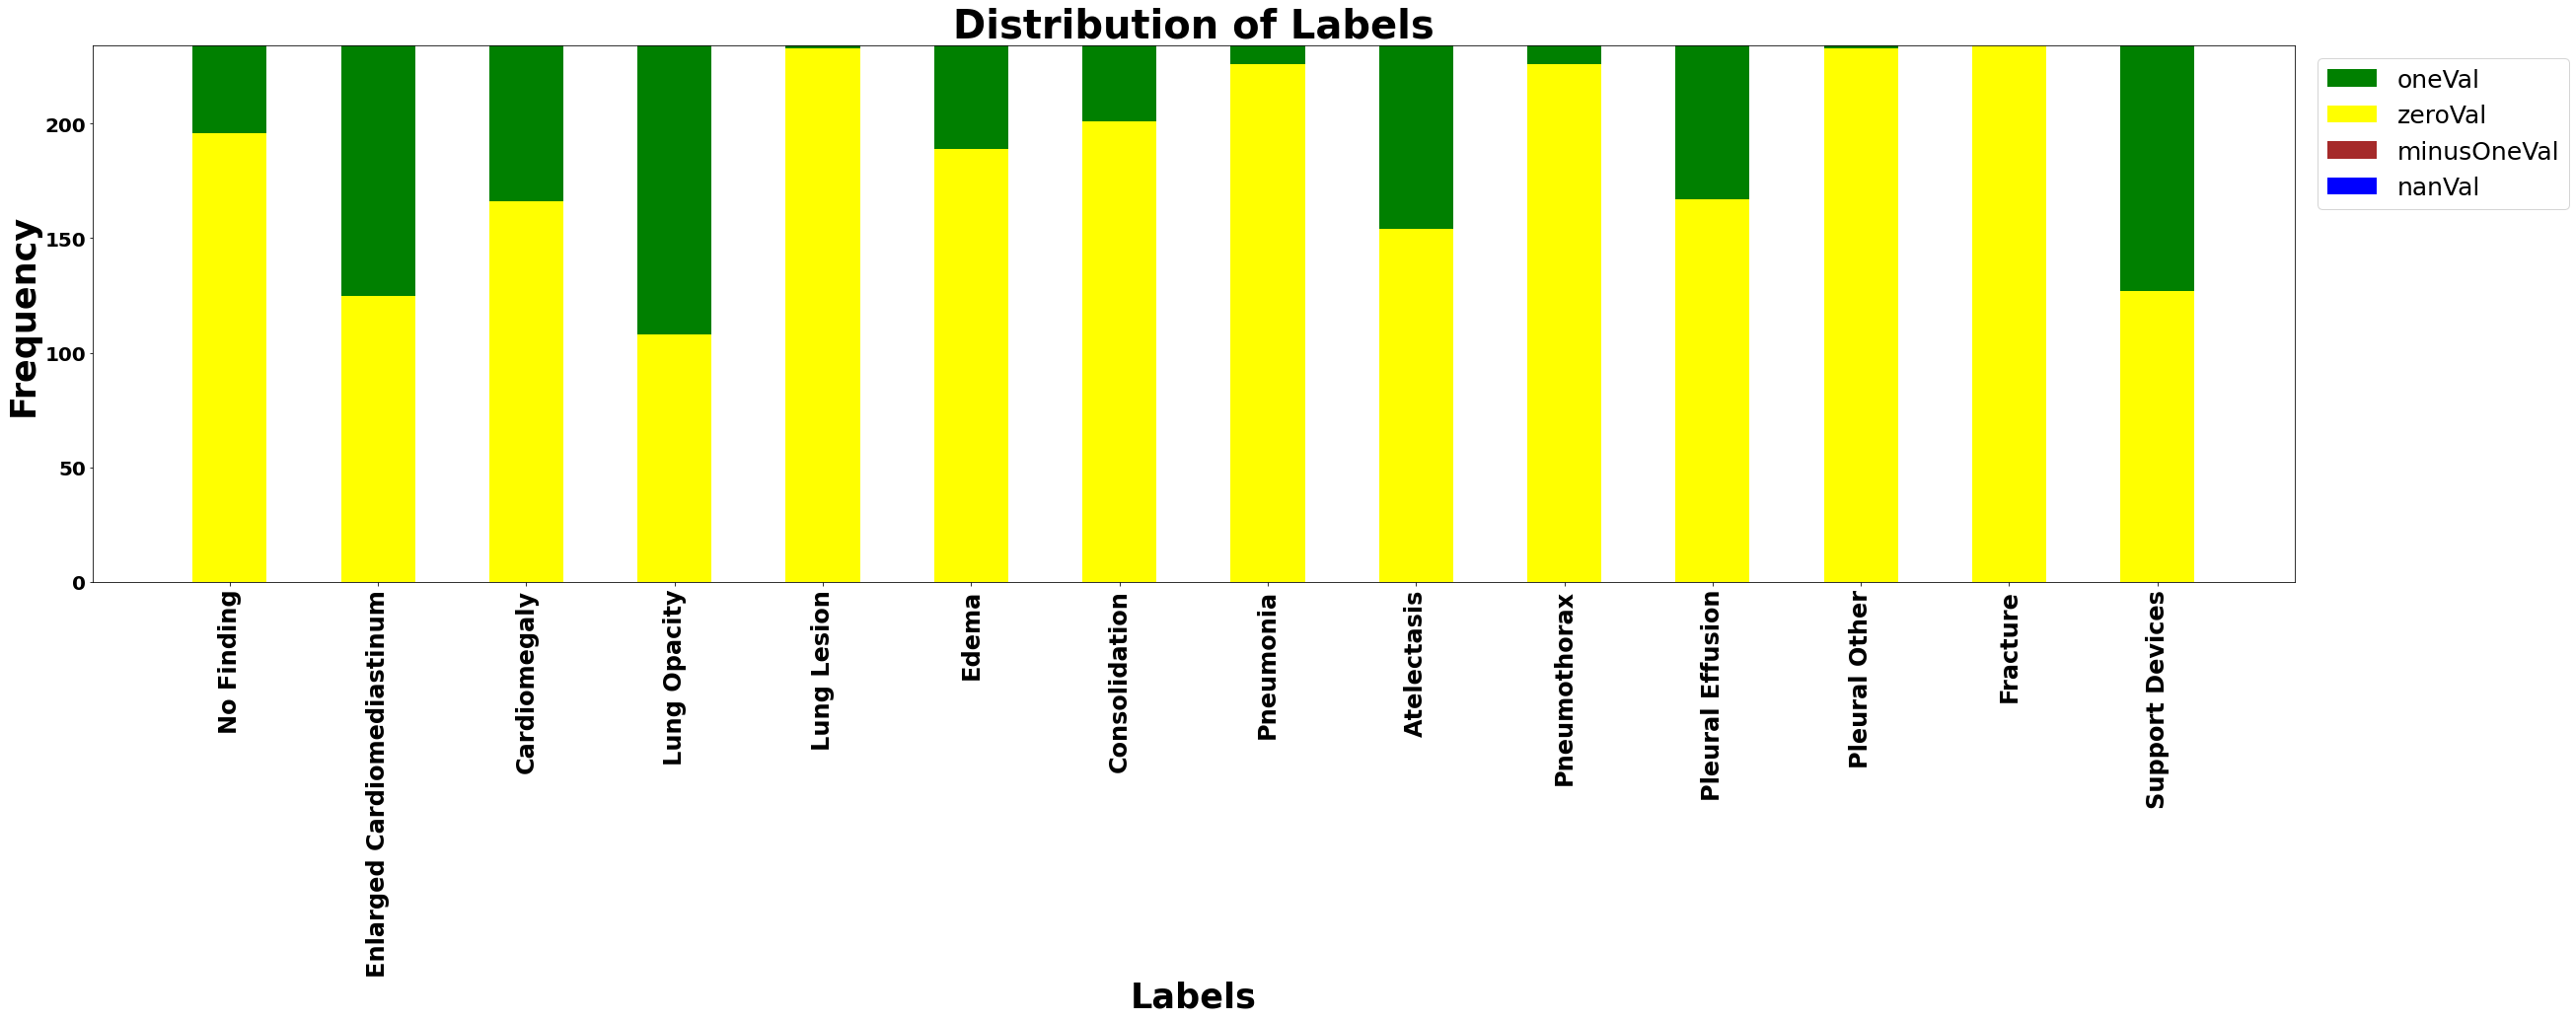

In [33]:
plt.figure(figsize=(40,10))
Label = data_df['Label']
nanVal = data_df['nanVal']
minusOneVal = data_df['minusOneVal']
zeroVal = data_df['zeroVal']
oneVal = data_df['oneVal']

ind = [x for x, _ in enumerate(Label)]

plt.bar(Label, oneVal, width=0.5, label='oneVal', color='green', bottom=zeroVal+minusOneVal+nanVal)
plt.bar(Label, zeroVal, width=0.5, label='zeroVal', color='yellow', bottom=minusOneVal+nanVal)
plt.bar(Label, minusOneVal, width=0.5, label='minusOneVal', color='brown',bottom=nanVal)
plt.bar(Label, nanVal, width=0.5, label='nanVal', color='blue')

plt.yticks(fontsize=20,fontweight='bold')

plt.xticks(ind, Label,fontsize=24,fontweight='bold',rotation=90)
plt.ylabel("Frequency",fontsize=35,fontweight='bold')
plt.xlabel("Labels",fontsize=35,fontweight='bold')
plt.legend(bbox_to_anchor=(1.005, 1),fontsize=25)
#plt.legend(bbox_to_anchor=(1.005, 1))
plt.title("Distribution of Labels",fontsize=40, fontweight='bold')

plt.show()

In [34]:
full_test_df.size

4446

## Test Data Loader

In [35]:
BATCH_SIZE = 1
test_dataset = ChestXrayDataset(my_data_path, full_test_df, IMAGE_SIZE, True)
#test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
for data, label in test_dataloader:
    print(data.size())
    print(label.size())
    break

torch.Size([1, 3, 224, 224])
torch.Size([1, 14])


In [36]:
del test_dataset
del full_test_df
gc.collect()

7706

### Functions for Prediction, Confusion Matrix and Plots

In [37]:
 def getTestPreds(best_model,test_dataloader,modeltxt):
    y_pred_t = torch.FloatTensor().to(device)      # Tensor stores prediction values
    y_test_t = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    y_pred_list = []
    y_test_list = []

    test_auroc = []
    test_acc = []
    test_f1 = []
    test_precision = []
    test_recall = []

    with torch.no_grad():

        best_model.eval()
        for X_batch, labels in test_dataloader:
            X_batch = X_batch.to(device)
            labels = labels.to(device)

            ps = best_model(X_batch)

            y_test_t = torch.cat((y_test_t,  labels), 0)
            y_pred_t = torch.cat((y_pred_t, ps), 0)
            
            test_acc.append(np.mean(multi_label_accuracy(y_test_t, y_pred_t)))
            test_f1.append(np.mean(multi_label_f1(y_test_t, y_pred_t)))
            test_auroc.append(np.mean(multi_label_auroc(y_test_t, y_pred_t)))
            
            p,r = multi_label_precision_recall(y_test_t, y_pred_t)
            test_precision.append(np.mean(p))
            test_recall.append(np.mean(r))
        
        test_auroc = np.nanmean(test_auroc)
        test_acc = np.nanmean(test_acc)
        test_f1 = np.nanmean(test_f1)
        test_precision = np.nanmean(test_precision)
        test_recall = np.nanmean(test_recall)
        
        
        print("AUROC : ",test_auroc)
        print("Accuracy : ",test_acc)
        print("f1 score : ",test_f1)
        print("precision score : ",test_precision)
        print("recall score : ",test_recall)
        
        eval_matrix = [modeltxt,test_auroc,test_acc,test_f1,test_precision,test_recall]
        
        return y_test_t,y_pred_t,eval_matrix

############## Plot
def plot_conf(y_test,y_pred,modeltxt):
    f, axes = plt.subplots(2, 7, figsize=(25, 8))
    f.suptitle('Confustion Matrix For Model '+ modeltxt, fontsize=20, fontweight='bold')
    plt.rcParams.update({'font.size': 14,'font.weight': 'bold'})
    y_test = y_test.cpu()
    y_pred = np.where(y_pred.cpu()>0.5,1,0)
    axes = axes.ravel()
    for i in range(14):
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                       y_pred[:, i]))
        disp.plot(ax=axes[i], values_format='.10g')
        disp.ax_.set_title(f'{LABELS[i]}')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()
    
################# Get Values

def get_conf(y_test,y_pred,modeltxt):
    conf_vals = []
    y_test = y_test.cpu()
    y_pred = np.where(y_pred.cpu()>0.5,1,0)
    for i in range(14):
        c = confusion_matrix(y_test[:, i],y_pred[:, i])
        #p = c[0][0]
        #q = c[0][1]
        #r = c[1][0]
       # s = c[1][1]
        try:
            p = c[0][0]
        except IndexError:
            p = 0

        try:
            q = c[0][1]
        except IndexError:
            q = 0
            
        try:
            r = c[1][0]
        except IndexError:
            r = 0
            
        try:
            s = c[1][1]
        except IndexError:
            s = 0
        
        conf_vals.append([modeltxt,LABELS[i],p,q,r,s])

    return conf_vals

## Test Predictions

In [38]:
eval_matrix_all = []
for mName in mName_list:
    print("Predicting for Model ",mName)
    globals()[f"y_test_t_{mName}"],globals()[f"y_pred_t_{mName}"],eval_matrix = getTestPreds(globals()[f"best_model_{mName}"],test_dataloader,mName)
    eval_matrix_all.append(eval_matrix)
    print("----------------------------------------------")

Predicting for Model  CustomNet
AUROC :  0.7537600133406136
Accuracy :  0.8631971394077436
f1 score :  0.24528801636028474
precision score :  0.38908212103120093
recall score :  0.20074939557981997
----------------------------------------------
Predicting for Model  DenseNet121
AUROC :  0.7838944810043479
Accuracy :  0.8661118865509148
f1 score :  0.2781139232578845
precision score :  0.3769061182384384
recall score :  0.2405177476737821
----------------------------------------------
Predicting for Model  ResNet50
AUROC :  0.7308193923776328
Accuracy :  0.8452452585373103
f1 score :  0.1833403551285868
precision score :  0.2829599313088333
recall score :  0.16907850556861498
----------------------------------------------
Predicting for Model  Inception
AUROC :  0.6921098095693519
Accuracy :  0.8297820273226124
f1 score :  0.1167743126554978
precision score :  0.16528302942802703
recall score :  0.09623468806091708
----------------------------------------------
Predicting for Model  Vgg

## Print and Plot Evaluation Matrices

### Print AUROC, Accuracy, F1 Score, Precision and Recall

In [39]:
df_mat_all = pd.DataFrame(eval_matrix_all)
df_mat_all.columns = ["Model Name","AUROC","Accuracy","F1 Score","Precision","Recall"]
df_mat_all

,Model Name,AUROC,Accuracy,F1 Score,Precision,Recall
0,CustomNet,0.753760,0.863197,0.245288,0.389082,0.200749
1,DenseNet121,0.783894,0.866112,0.278114,0.376906,0.240518
2,ResNet50,0.730819,0.845245,0.183340,0.282960,0.169079
3,Inception,0.692110,0.829782,0.116774,0.165283,0.096235
4,Vgg16,0.716072,0.838025,0.128222,0.186166,0.105025


### Print Accuracy for Labels

In [40]:
label_list_all = []
for mName in mName_list:
    #print("Model ",mName)
    for i in range(14):
        acc = accuracy_score(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], np.where(globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i]>=0.5,1,0))
        p = precision_recall_fscore_support(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], np.where(globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i]>=0.5,1,0),average='binary')
        #print(LABELS[i]," ==> ","Acc : ",acc," Precision : ",p[0]," Recall : ",p[1])  
        if i !=12:
            auroc = roc_auc_score(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i])
        else:
            auroc = np.nan
        
        #print(LABELS[i],p)
        label_list_all.append([mName,LABELS[i],auroc,acc,p[0],p[1]])
    

df_label_list_all = pd.DataFrame(label_list_all)
df_label_list_all.columns = ["Model Name","Label","AUROC","Accuracy","Precision","Recall"]
df_label_list_all.to_csv(out+"df_label_list_all.csv",index=False)
df_label_list_all

,Model Name,Label,AUROC,Accuracy,Precision,Recall
0,CustomNet,No Finding,0.865602,0.863248,0.650000,0.342105
1,CustomNet,Enlarged Cardiomediastinum,0.538789,0.534188,0.000000,0.000000
2,CustomNet,Cardiomegaly,0.757884,0.743590,1.000000,0.117647
3,CustomNet,Lung Opacity,0.864051,0.739316,0.865169,0.611111
4,CustomNet,Lung Lesion,0.047210,0.995726,0.000000,0.000000
...,...,...,...,...,...,...
65,Vgg16,Pneumothorax,0.830752,0.965812,0.000000,0.000000
66,Vgg16,Pleural Effusion,0.833318,0.777778,0.727273,0.358209
67,Vgg16,Pleural Other,0.656652,0.995726,0.000000,0.000000
68,Vgg16,Fracture,NaN,1.000000,0.000000,0.000000


## AUROC of Labels accross Different Models

In [41]:
df_label_list_all.pivot(index='Label', columns='Model Name', values=["AUROC"])

AUROC                                          
Model Name                 CustomNet DenseNet121 Inception  ResNet50     Vgg16
Label                                                                         
Atelectasis                 0.784740    0.824351  0.750568  0.753490  0.778571
Cardiomegaly                0.757884    0.834515  0.745836  0.724309  0.707123
Consolidation               0.841248    0.897332  0.672396  0.826624  0.817126
Edema                       0.882775    0.883598  0.811875  0.838566  0.788948
Enlarged Cardiomediastinum  0.538789    0.485358  0.512073  0.568807  0.520954
Fracture                         NaN         NaN       NaN       NaN       NaN
Lung Lesion                 0.047210    0.227468  0.085837  0.098712  0.287554
Lung Opacity                0.864051    0.911229  0.782775  0.823927  0.821355
No Finding                  0.865602    0.850161  0.843582  0.854189  0.872180
Pleural Effusion            0.865135    0.925552  0.780409  0.833676  0.833318
Pleural Other               0.935622    0.969957  0.849785  0.884120  0.656652
Pneumonia                   0.586836    0.682522  0.373341  0.605642  0.481195
Pneumothorax                0.632190    0.680310  0.681416  0.611173  0.830752
Support Devices             0.854588    0.882258  0.705276  0.748915  0.715652

## Accuracy of Labels accross Different Models

In [42]:
df_label_list_all.pivot(index='Label', columns='Model Name', values=["Accuracy"])

Accuracy                                          
Model Name                 CustomNet DenseNet121 Inception  ResNet50     Vgg16
Label                                                                         
Atelectasis                 0.700855    0.752137  0.658120  0.675214  0.658120
Cardiomegaly                0.743590    0.713675  0.709402  0.709402  0.709402
Consolidation               0.858974    0.858974  0.858974  0.858974  0.858974
Edema                       0.863248    0.863248  0.803419  0.811966  0.816239
Enlarged Cardiomediastinum  0.534188    0.534188  0.534188  0.534188  0.534188
Fracture                    1.000000    1.000000  1.000000  1.000000  1.000000
Lung Lesion                 0.995726    0.991453  0.995726  0.995726  0.995726
Lung Opacity                0.739316    0.782051  0.628205  0.756410  0.739316
No Finding                  0.863248    0.807692  0.837607  0.858974  0.837607
Pleural Effusion            0.833333    0.871795  0.782051  0.773504  0.777778
Pleural Other               0.995726    0.995726  0.995726  0.995726  0.995726
Pneumonia                   0.965812    0.965812  0.965812  0.965812  0.965812
Pneumothorax                0.965812    0.961538  0.965812  0.965812  0.965812
Support Devices             0.777778    0.769231  0.615385  0.679487  0.641026

## Precision of Labels accross Different Models

In [43]:
df_label_list_all.pivot(index='Label', columns='Model Name', values=["Precision"])

Precision                                          
Model Name                 CustomNet DenseNet121 Inception  ResNet50     Vgg16
Label                                                                         
Atelectasis                 0.777778    0.711538  0.000000  0.833333  0.000000
Cardiomegaly                1.000000    0.600000  0.000000  0.000000  0.000000
Consolidation               0.000000    0.000000  0.000000  0.000000  0.000000
Edema                       0.658537    0.632653  0.473684  0.520000  0.571429
Enlarged Cardiomediastinum  0.000000    0.000000  0.000000  0.000000  0.000000
Fracture                    0.000000    0.000000  0.000000  0.000000  0.000000
Lung Lesion                 0.000000    0.000000  0.000000  0.000000  0.000000
Lung Opacity                0.865169    0.941176  0.767123  0.810811  0.828283
No Finding                  0.650000    0.387097  0.000000  0.857143  0.500000
Pleural Effusion            0.769231    0.911111  0.722222  0.579545  0.727273
Pleural Other               0.000000    0.000000  0.000000  0.000000  0.000000
Pneumonia                   0.000000    0.000000  0.000000  0.000000  0.000000
Pneumothorax                0.000000    0.333333  0.000000  0.000000  0.000000
Support Devices             0.802198    0.827160  0.568000  0.656863  0.616162

In [44]:
df_label_list_all.pivot(index='Label', columns='Model Name', values=["Recall"])

Recall                                          
Model Name                 CustomNet DenseNet121 Inception  ResNet50     Vgg16
Label                                                                         
Atelectasis                 0.175000    0.462500  0.000000  0.062500  0.000000
Cardiomegaly                0.117647    0.044118  0.000000  0.000000  0.000000
Consolidation               0.000000    0.000000  0.000000  0.000000  0.000000
Edema                       0.600000    0.688889  0.200000  0.288889  0.177778
Enlarged Cardiomediastinum  0.000000    0.000000  0.000000  0.000000  0.000000
Fracture                    0.000000    0.000000  0.000000  0.000000  0.000000
Lung Lesion                 0.000000    0.000000  0.000000  0.000000  0.000000
Lung Opacity                0.611111    0.634921  0.444444  0.714286  0.650794
No Finding                  0.342105    0.315789  0.000000  0.157895  0.026316
Pleural Effusion            0.597015    0.611940  0.388060  0.761194  0.358209
Pleural Other               0.000000    0.000000  0.000000  0.000000  0.000000
Pneumonia                   0.000000    0.000000  0.000000  0.000000  0.000000
Pneumothorax                0.000000    0.125000  0.000000  0.000000  0.000000
Support Devices             0.682243    0.626168  0.663551  0.626168  0.570093

### Print Confusion Matrix

In [45]:
conf_all = pd.DataFrame()
for mName in mName_list:
    print("Print Confusion Matrix for Model ",mName)
    conf_all = conf_all.append(pd.DataFrame(get_conf(globals()[f"y_test_t_{mName}"],globals()[f"y_pred_t_{mName}"],mName)))

Print Confusion Matrix for Model  CustomNet
Print Confusion Matrix for Model  DenseNet121
Print Confusion Matrix for Model  ResNet50
Print Confusion Matrix for Model  Inception
Print Confusion Matrix for Model  Vgg16


In [46]:
conf_all.columns = ["Model Name","Label","True Negative","False Positive","False Negative","True Positive"]
conf_all.to_csv("ConfusionMatrix.csv",index=False)
conf_all_piv = conf_all.pivot(index='Label', columns='Model Name', values=["True Negative","False Positive","False Negative","True Positive"])
conf_all_piv.to_csv(out+"ConfusionMatrixPivot.csv",index=False)
conf_all_piv

True Negative                                       \
Model Name                     CustomNet DenseNet121 Inception ResNet50 Vgg16   
Label                                                                           
Atelectasis                          150         139       154      153   154   
Cardiomegaly                         166         164       166      166   166   
Consolidation                        201         201       201      201   201   
Edema                                175         171       179      177   183   
Enlarged Cardiomediastinum           125         125       125      125   125   
Fracture                             234         234       234      234   234   
Lung Lesion                          233         232       233      233   233   
Lung Opacity                          96         103        91       87    91   
No Finding                           189         177       196      195   195   
Pleural Effusion                     155         163       157      130   158   
Pleural Other                        233         233       233      233   233   
Pneumonia                            226         226       226      226   226   
Pneumothorax                         226         224       226      226   226   
Support Devices                      109         113        73       92    89   

                           False Positive                                 \
Model Name                      CustomNet DenseNet121 Inception ResNet50   
Label                                                                      
Atelectasis                             4          15         0        1   
Cardiomegaly                            0           2         0        0   
Consolidation                           0           0         0        0   
Edema                                  14          18        10       12   
Enlarged Cardiomediastinum              0           0         0        0   
Fracture                                0           0         0        0   
Lung Lesion                             0           1         0        0   
Lung Opacity                           12           5        17       21   
No Finding                              7          19         0        1   
Pleural Effusion                       12           4        10       37   
Pleural Other                           0           0         0        0   
Pneumonia                               0           0         0        0   
Pneumothorax                            0           2         0        0   
Support Devices                        18          14        54       35   

                                 False Negative                        \
Model Name                 Vgg16      CustomNet DenseNet121 Inception   
Label                                                                   
Atelectasis                    0             66          43        80   
Cardiomegaly                   0             60          65        68   
Consolidation                  0             33          33        33   
Edema                          6             18          14        36   
Enlarged Cardiomediastinum     0            109         109       109   
Fracture                       0              0           0         0   
Lung Lesion                    0              1           1         1   
Lung Opacity                  17             49          46        70   
No Finding                     1             25          26        38   
Pleural Effusion               9             27          26        41   
Pleural Other                  0              1           1         1   
Pneumonia                      0              8           8         8   
Pneumothorax                   0              8           7         8   
Support Devices               38             34          40        36   

                                          True Positive                        \
Model Name                 ResNet

### Plot Confusion Matrix

Plot Confusion Matrix for Model  CustomNet


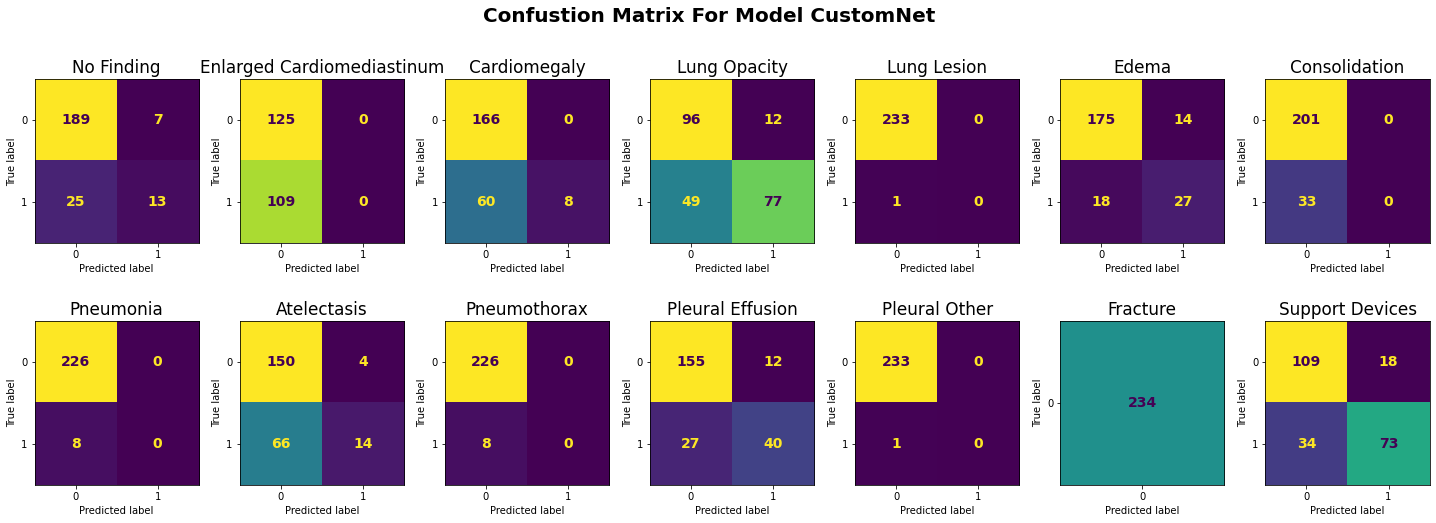

Plot Confusion Matrix for Model  DenseNet121


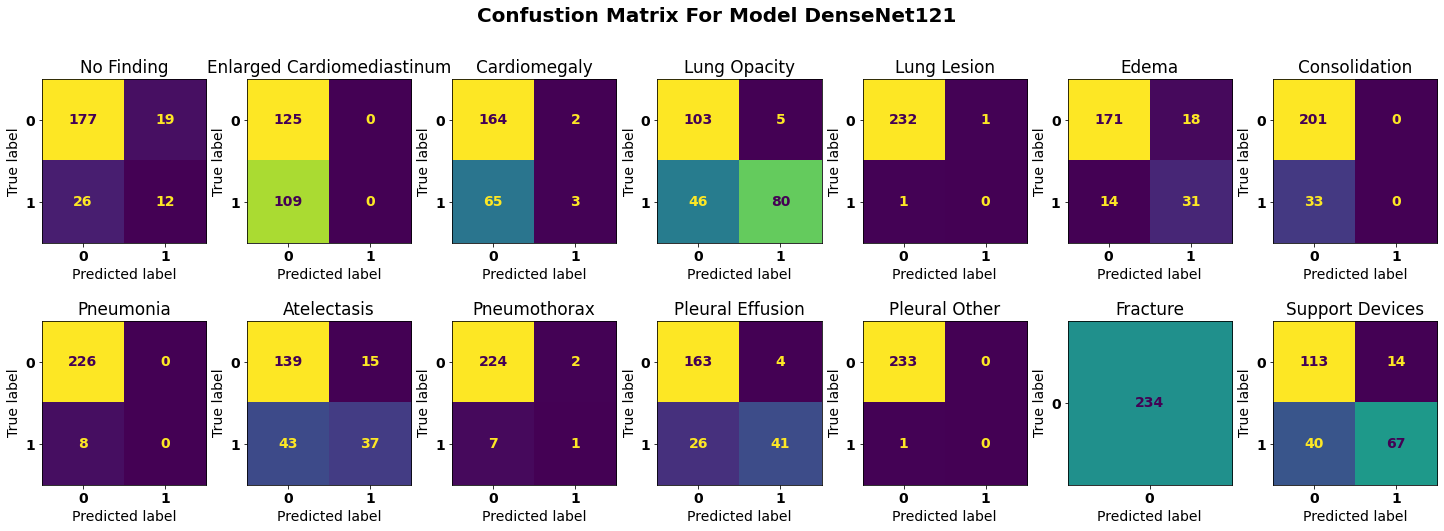

Plot Confusion Matrix for Model  ResNet50


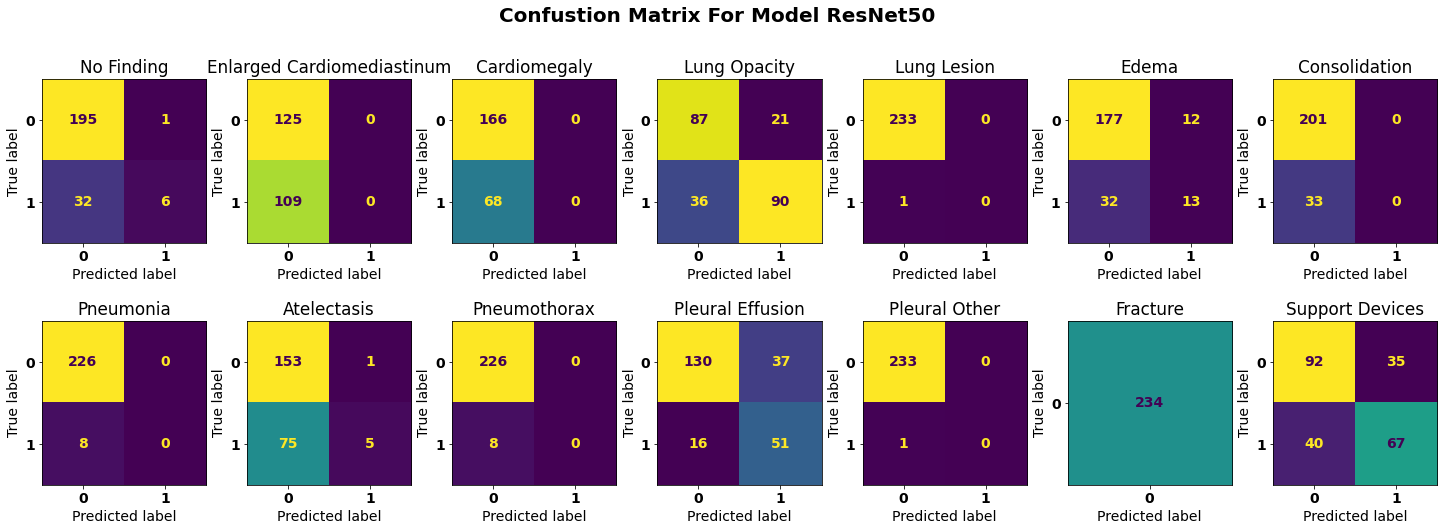

Plot Confusion Matrix for Model  Inception


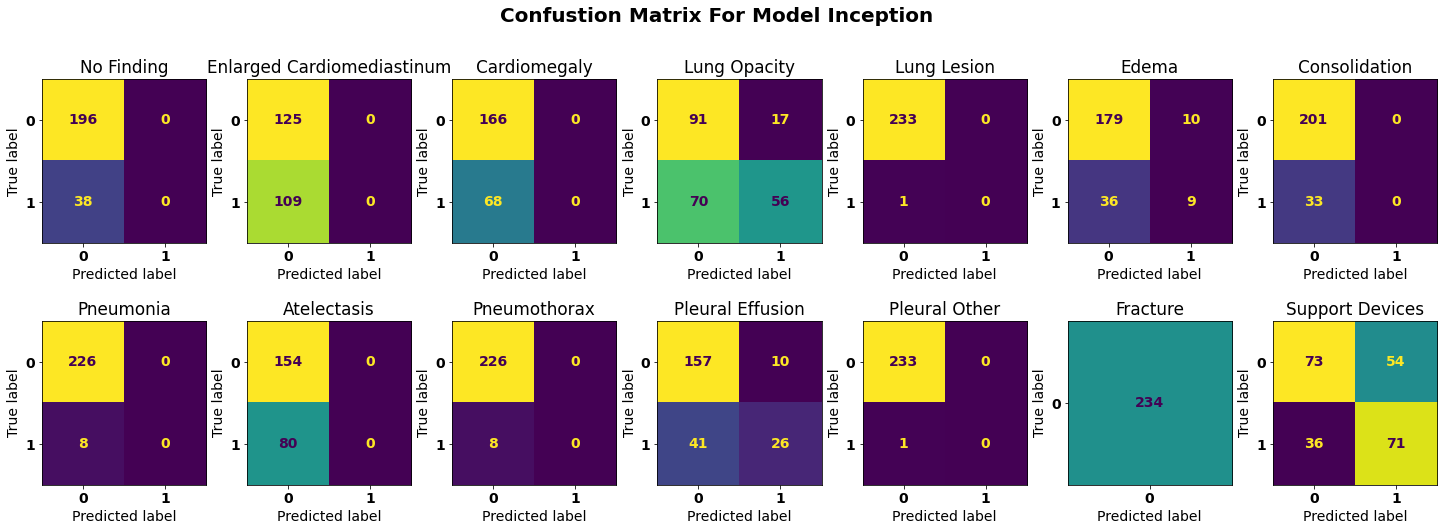

Plot Confusion Matrix for Model  Vgg16


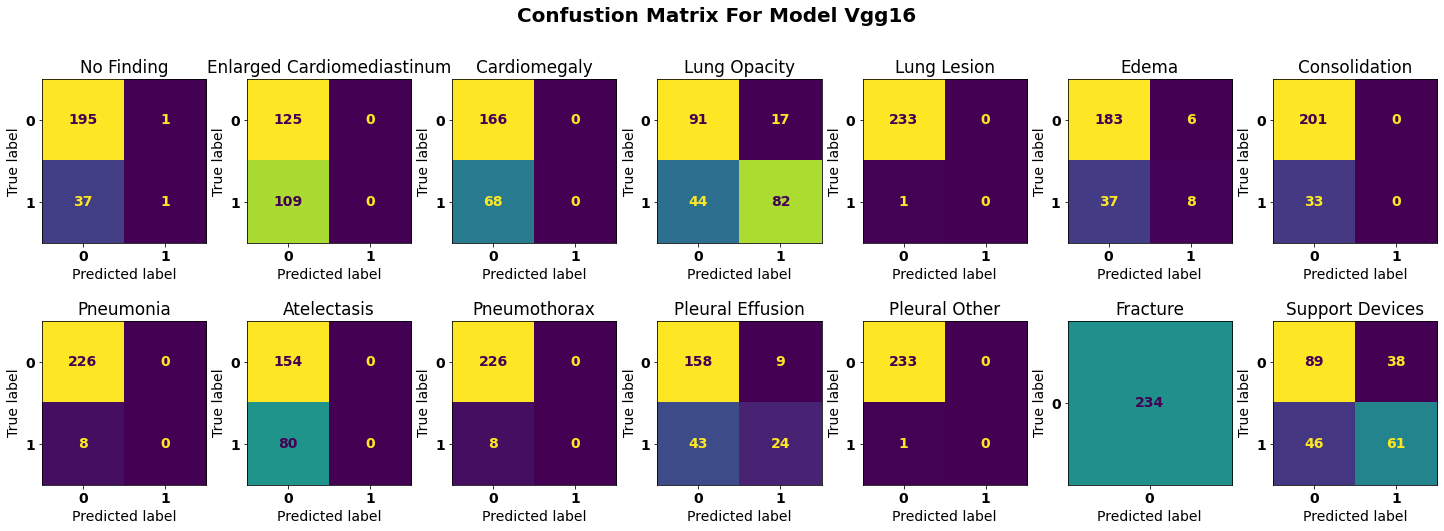

In [47]:
conf_all = pd.DataFrame()
for mName in mName_list:
    print("Plot Confusion Matrix for Model ",mName)
    plot_conf(globals()[f"y_test_t_{mName}"],globals()[f"y_pred_t_{mName}"],mName)

In [48]:
print("All Done")

All Done
